In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.applications import MobileNet



Using TensorFlow backend.


In [3]:
img_rows, img_cols = 224, 224
MobileNet = MobileNet(weights = 'imagenet',
                     input_shape = (img_rows, img_cols, 3),
                     include_top = False)


17227776/17225924 [==============================] - 0s 0us/step


In [4]:
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False


In [5]:
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

In [6]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model


num_classes = 2

FC_Head = lw(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_path = os.getcwd()
print(base_path)
validation_data_dir = '../input/cat-and-dog/test_set/test_set'
train_data_dir = '../input/cat-and-dog/training_set/training_set'
print(train_data_dir)

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

/kaggle/working
../input/cat-and-dog/training_set/training_set
Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [9]:
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
                     
checkpoint = ModelCheckpoint("recog.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 8005
nb_validation_samples = 2023

# We only train 5 EPOCHS 
epochs = 5
batch_size = 64

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.8788
Epoch 00001: val_loss improved from inf to 0.06481, saving model to recog.h5
125/125 [==============================] - 171s 1s/step - loss: 0.5425 - accuracy: 0.8788 - val_loss: 0.0648 - val_accuracy: 0.9758
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9380
Epoch 00002: val_loss improved from 0.06481 to 0.03967, saving model to recog.h5
125/125 [==============================] - 170s 1s/step - loss: 0.1651 - accuracy: 0.9380 - val_loss: 0.0397 - val_accuracy: 0.9919
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9520
Epoch 00003: val_loss did not improve from 0.03967
125/125 [==============================] - 162s 1s/step - loss: 0.1281 - accuracy: 0.9520 - val_loss: 0.0697 - val_accuracy: 0.9849
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9525
Epoch 00004: va

cat.4184.jpg
[[0.3707921  0.62920785]]
['_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_inbound_node', '_add_trackable', '_add_variable_with_custom_getter', '_assert_compile_was_called', '_assert_weights_created', '_attribute_sentinel', '_auto_track_sub_layers', '_autocast', '_base_init', '_build_input_shape', '_call_accepts_kwargs', '_call_arg_was_passed', '_call_fn_args', '_call_full_argspec', '_callable_losses', '_check_call_args', '_checkpoint_dependencies', '_clear_losses', '_collect_input_masks', '_compile_was_called', '_compiled_trainable_state', '_compute_dtype', '_compute_output_a

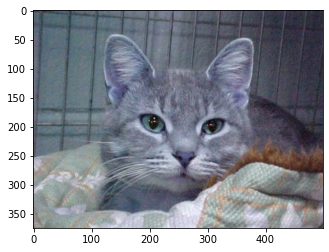

In [20]:
from matplotlib import pyplot as plt
import cv2
model.save("recog.h5")
directory = os.listdir("../input/cat-and-dog/test_set/test_set/cats")
print(directory[111])

for i in range(10):
    imgCat = cv2.imread("../input/cat-and-dog/test_set/test_set/cats/" + directory[i])
    plt.imshow(imgCat)

    imgCat = cv2.resize(imgCat, (img_rows,img_cols))
    imgCat = imgCat.reshape(1,img_rows,img_cols,3)

    pred = model.predict(imgCat)
    print(pred)

#print(dir(model))
#print(model.__class__)